<a href="https://colab.research.google.com/github/abduyea/Optimizing-Deep-Learning-Pipelines/blob/main/Optimizing_Deep_Learning_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Abdulfetah

In [6]:
# setup
%pip -q install -U seaborn scikit-learn black flake8


In [9]:
# Import pacakge and libreries
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2

#  reproducibility
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [12]:
#Helper function
def plot_history(history, title="Training Curves"):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure()
    plt.plot(epochs, h["accuracy"], label="train_acc")
    plt.plot(epochs, h.get("val_accuracy", []), label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} — Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, h["loss"], label="train_loss")
    plt.plot(epochs, h.get("val_loss", []), label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} — Loss")
    plt.legend()
    plt.show()


def plot_confmat(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=False, fmt="d", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def classif_report_df(y_true, y_pred, labels=None):
    rep = classification_report(y_true, y_pred, target_names=labels, output_dict=True, zero_division=0)
    df = pd.DataFrame(rep).transpose()
    return df.round(3)

In [25]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [26]:
DATA_DIR = "/content/drive/MyDrive/Sign Language MNIST"

train_path = os.path.join(DATA_DIR, "sign_mnist_train", "sign_mnist_train.csv")
test_path  = os.path.join(DATA_DIR, "sign_mnist_test", "sign_mnist_test.csv")

for p in (train_path, test_path):
    print(p, "→", os.path.isfile(p))


/content/drive/MyDrive/Sign Language MNIST/sign_mnist_train/sign_mnist_train.csv → True
/content/drive/MyDrive/Sign Language MNIST/sign_mnist_test/sign_mnist_test.csv → True


In [28]:
#Load CSVs → DataFrames
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)



Train shape: (27455, 785)
Test  shape: (7172, 785)


In [30]:
#Split features/labels
y_train = train_df["label"].to_numpy()
y_test  = test_df["label"].to_numpy()

X_train_img = train_df.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28)
X_test_img  = test_df.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28)

print("X_train_img:", X_train_img.shape, X_train_img.dtype)
print("X_test_img :", X_test_img.shape,  X_test_img.dtype)
print("y_train unique:", len(np.unique(y_train)))


X_train_img: (27455, 28, 28) int64
X_test_img : (7172, 28, 28) int64
y_train unique: 24


In [32]:
# Normalize to [0,1] and prepare flat arrays for dense models
X_train_img = (X_train_img / 255.0).astype("float32")
X_test_img  = (X_test_img  / 255.0).astype("float32")

# Dense models expect vectors; keep both forms (flat for models, 2D for plots)
X_train = X_train_img.reshape(-1, 28 * 28)
X_test  = X_test_img.reshape(-1, 28 * 28)

print("X_train (flat):", X_train.shape, X_train.dtype)
print("X_test  (flat):", X_test.shape,  X_test.dtype)
print("Label range:", y_train.min(), "→", y_train.max())


X_train (flat): (27455, 784) float32
X_test  (flat): (7172, 784) float32
Label range: 0 → 24


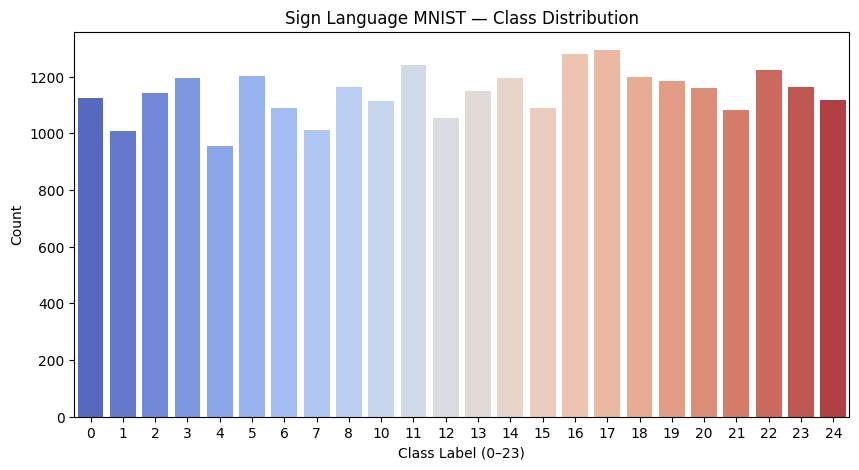

In [33]:
#Class Distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y_train, palette="coolwarm")
plt.title("Sign Language MNIST — Class Distribution")
plt.xlabel("Class Label (0–23)")
plt.ylabel("Count")
plt.show()



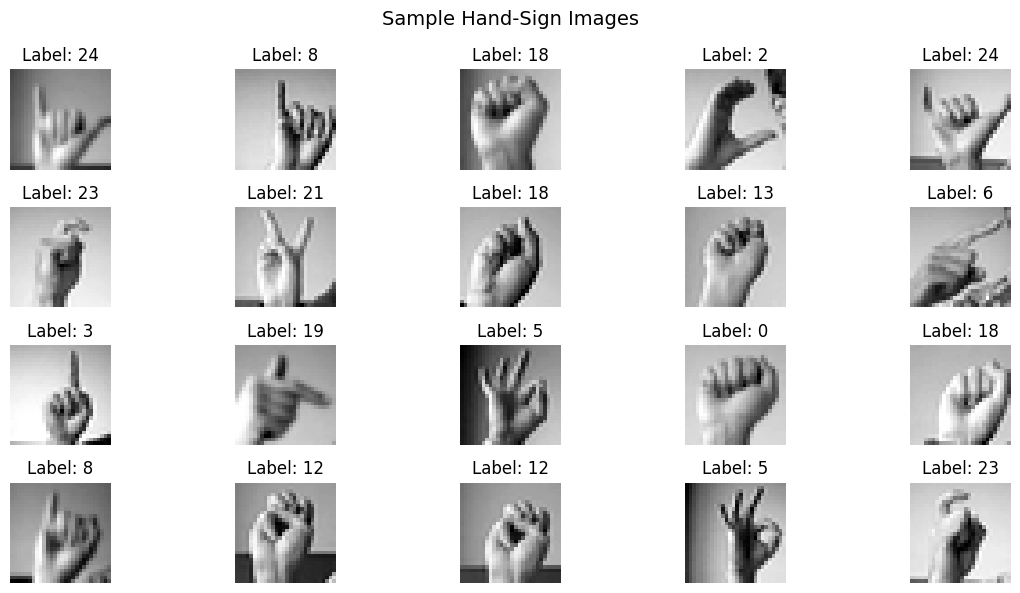

In [34]:
# Display Sample Images
# show 20 random training samples
plt.figure(figsize=(12,6))
for i, idx in enumerate(np.random.choice(len(X_train_img), 20, replace=False)):
    plt.subplot(4,5,i+1)
    plt.imshow(X_train_img[idx], cmap="gray")
    plt.title(f"Label: {y_train[idx]}")
    plt.axis("off")
plt.suptitle("Sample Hand-Sign Images", fontsize=14)
plt.tight_layout()
plt.show()


In [35]:
# Statics
print("Image pixel value range:", X_train_img.min(), "→", X_train_img.max())
print("Mean pixel value:", round(X_train_img.mean(),3))
print("Std dev of pixels:", round(X_train_img.std(),3))
print("Number of classes:", len(np.unique(y_train)))


Image pixel value range: 0.0 → 1.0
Mean pixel value: 0.625
Std dev of pixels: 0.191
Number of classes: 24


In [49]:
#Model Definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

baseline_model = Sequential([
    Dense(256, activation="relu", input_shape=(784,)),
    Dense(128, activation="relu"),
    Dense(24, activation="softmax")
])

baseline_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
#Training
history_baseline = baseline_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1665655626.py", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 2330, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py", line 2000, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py", line 753, in sparse_categorical_crossentropy

Received a label value of 24 which is outside the valid range of [0, 24).  Label values: 17 8 1 13 21 16 16 15 6 1 22 18 2 6 24 21 23 7 19 17 23 17 8 10 15 1 10 10 8 10 7 13 23 7 18 12 20 14 2 21 11 4 13 23 5 10 24 1 11 2 18 18 3 23 12 13 21 1 13 14 21 20 1 8 8 0 22 19 3 6 8 4 13 1 19 4 11 7 22 14 16 14 13 19 3 24 6 24 24 19 16 1 15 11 22 11 3 19 6 24 11 13 11 19 0 22 12 23 6 4 11 10 16 11 24 12 16 7 23 21 14 3 10 7 5 2 20 0
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_3867]

In [52]:
# Plot Curves
plot_history(history_baseline, title="Baseline Model (Adam)")


NameError: name 'history_baseline' is not defined